# Data Assimilation for Lorenz model

- 基本的なカオス系であるLorenzモデルを使用してデータ同化のデモンストレーションを行う
- Wikipedia: [ローレンツ方程式](https://ja.wikipedia.org/wiki/%E3%83%AD%E3%83%BC%E3%83%AC%E3%83%B3%E3%83%84%E6%96%B9%E7%A8%8B%E5%BC%8F)

In [3]:
%matplotlib inline

In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import DA

- 真の時系列を生成（答え合わせ用）

In [6]:
df = DA.misc.generate_l63_timeseries(dt=0.01, T=5000, x0=np.array([1.0, 0, 0]))[20:]

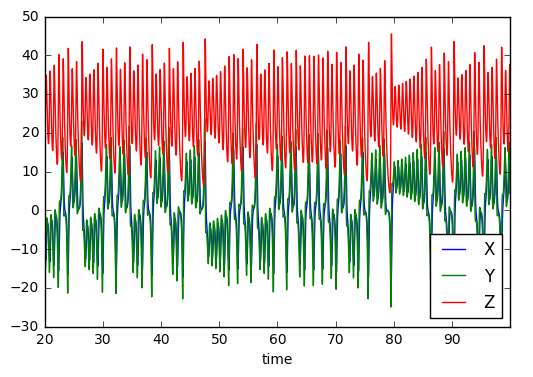

In [7]:
df.plot()

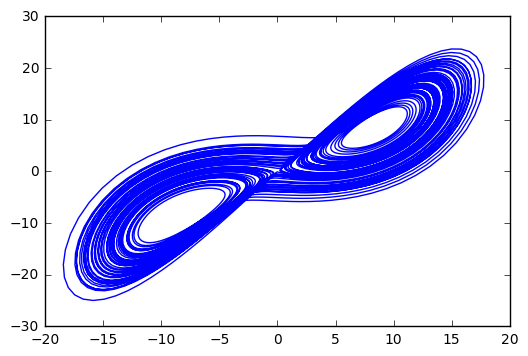

In [8]:
plt.plot(df["X"], df["Y"])

## Ensemble Transform Kalman Filter (ETKF)

- $\tau = 0.25$毎に観測する
- 観測では分散１のノイズが入る

In [9]:
H = DA.observation.trivial(3) # 観測演算子
R = 1.0*np.eye(3)             # 観測ノイズの共分散行列
tau = 25
dt = 0.01
U = DA.model.RK4(DA.model.Lorenz63(p=10., r=28., b=8./3.), dt=dt, T=tau) # tau進む時間発展演算子
F = DA.ensemble.forcast(U)  # Forecast step
A = DA.ETKF.analysis(H, R)  # Analysis step

- アンサンブルを用意する

In [10]:
x0 = np.array(df.head(1))[0]

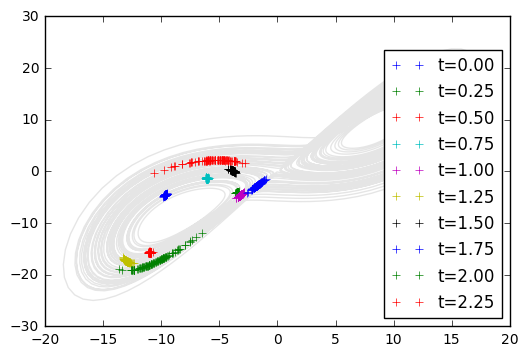

In [11]:
plt.plot(df["X"], df["Y"], "gray", alpha=0.2, label="")
xs = DA.ensemble.replica(x0, K=100, noise=0.1)
for t in range(10):
    xs = F(xs)
    plt.plot(xs[:, 0], xs[:, 1], "+", label="t={:.02f}".format(t*0.25))
plt.legend(loc=4)

$ \sigma = \sqrt{\text{Tr} P}$, $P_{ij} = \left< (x-\left<x\right>)_i (x-\left<x\right>)_j  \right>$

In [12]:
def sigma(xs):
    return np.sqrt(np.cov(xs.T).trace())

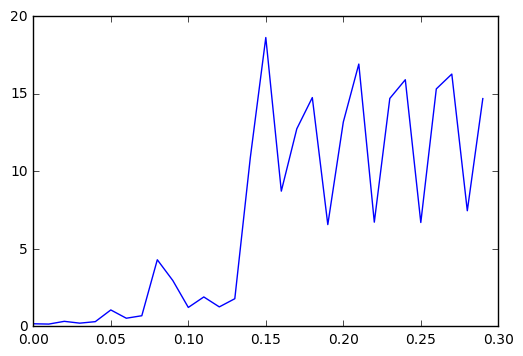

In [13]:
spreads = []
xs = DA.ensemble.replica(x0, K=100, noise=0.1)
for t in range(30):
    xs = F(xs)
    spreads.append(sigma(xs))
plt.plot(np.arange(0, 30*dt, dt), spreads)

In [14]:
obs = []
for idx, (time, data) in enumerate(df.iterrows()):
    if idx % tau != 0:
        continue
    obs.append((time, np.array(data) + np.random.normal(size=3)))

In [15]:
truth = []
for idx, (time, data) in enumerate(df.iterrows()):
    if idx % tau == 0:
        truth.append((time, np.array(data)))

In [16]:
obs_df = pd.DataFrame([(time, data[0]) for time, data in obs], columns=["time", "obsX"])

(60, 70)

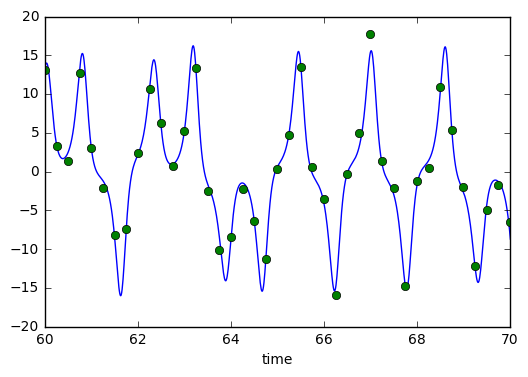

In [17]:
df["X"].plot()
plt.plot(obs_df["time"], obs_df["obsX"], "o")
plt.xlim(60, 70)

In [18]:
ss = []
xs = DA.ensemble.replica(x0, K=6, noise=0.1)
for (time, y), (_, t) in zip(obs, truth):
    xs = A(xs, y)
    xm = np.mean(xs, axis=0)
    xs = F(xs)
    ss.append((time, np.linalg.norm(xm-t), sigma(xs)))
sigma_df = pd.DataFrame(ss, columns=["time", "dev", "sigma"]).set_index("time")

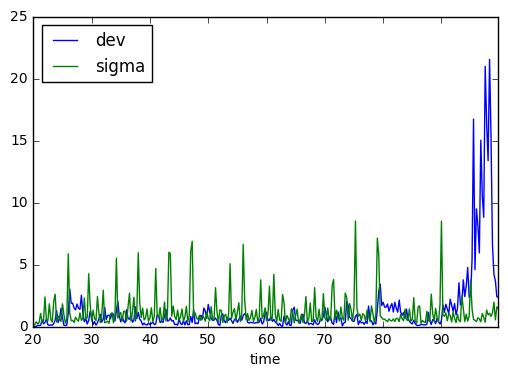

In [19]:
sigma_df.plot()